# Personal playground for LCP project
### Barone Francesco Pio

##### UniPD, AY 2021/22

### Load & set up dataframe

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import math
from scipy import stats

source_file = '/data/Run000262/data_000000.txt'

In [2]:
# loading the dataset
data = pd.read_csv(source_file, sep=",")
print(f'I loaded a dataset of {len(data)} hits')

I loaded a dataset of 1310592 hits


The following code adds columns to the dataframe.
- There are 4 detectors managed by to two FPGAs. FPGA 0 maps detector 1 in channels $[1,64]$, detector 2 in channels $[65,128]$. The same boundaries work for detector 3 and 4, which are managed by FPGA 1.

```python
#observation: this alternative is slower, but handles the special channels... ##
def tell_detector(tdc, fpga):
    if tdc > 129: return 0  # filter out the special events
    else: return np.ceil(tdc/64) + 2*fpga
data['detector'] = data.apply(lambda x: tell_detector(x["TDC_CHANNEL"], x["FPGA"]), axis=1)
```

In [3]:
### dataframe elaboration

# detector, layer, tile
data['detector'] = pd.Series( (data["TDC_CHANNEL"]/64).apply(np.ceil) + data["FPGA"]*2 , dtype='int')
data['layer'] = pd.Series( data.TDC_CHANNEL%4, dtype='int')
data['layer'].replace( {0:1, 2:2, 3:3, 1:4}, inplace=True)
data['tile']  = pd.Series( ( ((data.TDC_CHANNEL-1)%64)/4 ).apply(np.floor) , dtype='int')

# time [ns]
t0 = data.ORBIT_CNT.min() # NOTE: because ORBIT_CNT is huge, I shift the time values by the minimum ORBIT_CNT
data['t'] = pd.Series( (data.ORBIT_CNT-t0)*3564*25 + data.BX_COUNTER*25 + data.TDC_MEAS*25/30)

# manage trigger hits
data = data.rename(columns={"HEAD": "trigger"})  # since HEAD is useless, I use it as a trigger marker
data.loc[data.TDC_CHANNEL > 128, ['detector','layer','tile']] = 0  # because these values do not make sense for triggers
data.loc[data.TDC_CHANNEL <= 128, 'trigger'] = 0

# misc
data.head(10)

,trigger,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,detector,layer,tile,t
0,0,1,19,1965859059,2882,5,3,3,4,7.205417e+04
1,0,1,37,1965859067,931,1,3,4,9,7.360758e+05
2,0,0,25,1965859082,1906,19,1,4,6,2.096966e+06
3,0,0,25,1965859082,1916,17,1,4,6,2.097214e+06
4,0,1,82,1965859090,3415,5,4,2,4,2.847479e+06
5,0,0,75,1965859093,1227,17,2,3,2,3.060089e+06
6,0,0,63,1965859094,875,24,1,3,15,3.140395e+06
7,0,0,10,1965859101,1100,2,1,2,2,3.769702e+06
8,0,0,47,1965859117,668,3,1,3,11,5.184502e+06
9,0,1,74,1965859120,2465,10,4,2,2,5.496733e+06


This dataset has 99338.0 triggers.


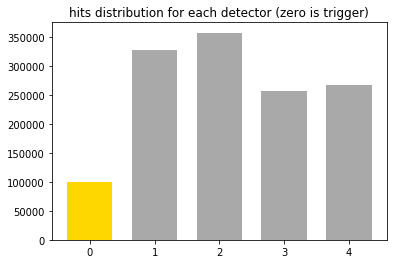

In [4]:
# looking at the distribution of data for each detector
plt.title('hits distribution for each detector (zero is trigger)')
data_distribution,_,patches = plt.hist(data.detector, np.arange(0, 6)-0.5 , rwidth = 0.7, color = 'darkgrey')
patches[0].set_facecolor('gold')
del patches
print(f'This dataset has {data_distribution[0]} triggers.')
plt.show()

These cells are intentionally left blank for playground purpose.

In [5]:
#data[data['ORBIT_CNT'] == 1965859223]
#data[410:430]

# to loop over all orbits in dataframe
#df = data.groupby(['ORBIT_CNT'])       
        
#counter = 0
#for orbit_id, orbit_subframe in data.groupby(['ORBIT_CNT']):
#    n_trig = orbit_subframe['trigger'].sum()
#    counter += 1
#    if not counter%1000: print(counter)

## Utility functions

### Plotters

In [68]:
def plot_events_from_tiles(ev, title = None, note = None, limited_area = False):
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # create the the detector pattern
    color_list = ['tomato','orange','gold','dodgerblue', 'green', 'r', 'b', 'y']
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    tiles = []
    for jj in range(n_layers):
        row = []
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy),dx,dy, edgecolor='dimgray',facecolor='none', linewidth=0.7)
            ax.add_patch( t )
            row.append(t)
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
        tiles.append(row)
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy*5, dy*n_layers + 5);
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.xaxis.set_visible(False);    ax.yaxis.set_visible(False);
    #ax.axis('off')  # completely turn off the axis, if you wish
    
    if note:  ax.text(0, -17, note, size=8)
    if title: plt.title(title)
    
    if limited_area: tiles_range = []
    
    for idx, e in enumerate(ev):
        
        lal = "[{:03d}] {:.2f}".format(e[0],e[1])
        if idx != 0:
            lal += " ({:+.2f})".format(e[1]-prev_time)
        tiles[e[2]-1][e[3]].set(facecolor=(color_list[idx]),label=lal)
        prev_time = e[1]
        if limited_area: tiles_range.append(e[3])    
    
    if limited_area:  # if true, plots only the appropriate range of tiles
        plt.xlim( -3 + dx*(min(tiles_range)-1), 3 + dx*max(tiles_range) + 3*dx/2)
        plt.ylim( -dy, dy*n_layers + 5)
        plt.axis('off')
    else:
        plt.legend(prop={'size': 7},  bbox_to_anchor=(1, 0.42))
    
    plt.show()    
    return tiles

def plot_event(dic, title = None):
    plot_events_from_tiles(dic["event"], title=title, note=f' from orbit {dic["orbit"]}, number # {dic["orbit_event"]}')

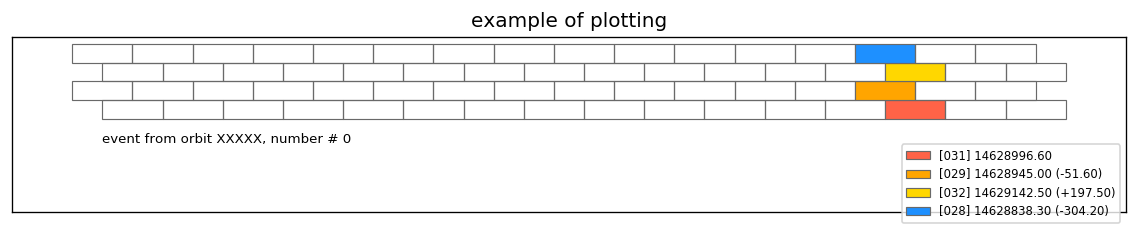

We can also plot only the interested zone of the detector, using limited_area = True:


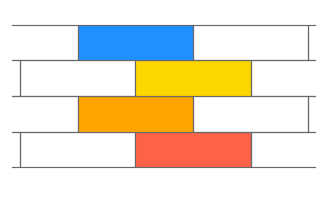

<Figure size 432x288 with 0 Axes>

In [8]:
## USE OF THE PLOT FUNCTIONS:

# required arguments: list of tuples containing the hit events
#   each tuple contains, in this format:   ( HIT_ID, time, layer, tile)

plot_events_from_tiles(  [ (31, 14628996.6, 1, 13), 
                           (29, 14628945.0, 2, 13), 
                           (32, 14629142.5, 3, 13), 
                           (28, 14628838.3, 4, 13) ],
                        title = 'example of plotting', note = 'event from orbit XXXXX, number # 0');

print('We can also plot only the interested zone of the detector, using limited_area = True:')
plot_events_from_tiles( [ (31, 14628996.6, 1, 13), (29, 14628945.0, 2, 13), (32, 14629142.5, 3, 13), (28, 14628838.3, 4, 13) ],
                        limited_area = True );
plt.savefig('img/chain.png');

# Search algorithms

In this section we propose different algorithms to search for physical events in a dataframe.

### Algorithm 1: proximity tracker

This algorithm searches for **sequences of hits** in a dataframe. A hit sequence might look like this:

![alt text](./img/chain.png)

This algorithm looks at the hits in a dataframe, one by one. For each hit, the algorithm looks at the upper layers for other hits

In [6]:
## DEFINING THE FUNCTIONS:

def proximity_tracker(dgg, hit_id, chain, events, debug = False, discard_pairs = True):   # the algorithm used to associate hits into possible tracks
    #  inputs:  dgg      the dataframe used to withdraw data
    #           hit_id   the ID of the hit event upon which the recursive algorithm is called
    #           stri     the string containing the events succession of 
    #           events   a list of events (initialized by external function)
    
    # function parameters:
    dt = 415  # time tolerance
    
    if debug: print(f'\nalgorithm called on hit {hit_id}')
    
    # initialize the function values from the dataframe
    me = dgg.loc[ hit_id ]
    t, l, c  = me.t, int(me.layer), int(me.tile)
    me_output = (hit_id, t, l, c)
    chain.append( me_output )
    
    if l == 4:    # no need to call the algo again
        if debug: print('append_shorter', chain,'\n')
        
        if discard_pairs: # append nothing if chain is only made of 2 events
            if len(chain) < 3: return 0
        
        events.append(  chain  )
        return 1
    
    # search for other hits nearby the current hit
    candidates = []
    for dl in range(1,5-l):
        lay = l+dl
        c_up = c + math.floor((dl+(l%2))/2)
        c_down = c_up - dl
        if debug: print(f' looking at layer {lay} for indexes {c_down} to {c_up}')
        
        candidate_df = (dgg['layer'] == l+dl) & (dgg['t'] > t-dt) & (dgg['t'] <= t+dt*dl) & (dgg['tile'] <= c_up) & (dgg['tile']>= c_down)
        candidates = candidates + dgg[candidate_df].index.values.tolist()
    
    if debug: print('candidates:', candidates)
    
    if not candidates:  # there are no candidates, end the function
        
        if discard_pairs: # append nothing if chain is only made of 2 events
            if len(chain) < 3: return 0
        
        events.append(  chain  )
        return 1
    
    for cc in candidates:   # call the (recursive) algorithm on the candidates
        proximity_tracker(dgg, cc, chain.copy(), events, debug=debug, discard_pairs=discard_pairs)
    return 0


    
def discard_similar(chains, debug = False):
    if debug:
        print('(discard_similar) before')
        for c in chains:  print(c)
    unique_data = [ list(x) for x in set(tuple(x) for x in chains) ]
    if debug:
        print('after')
        for c in unique_data:  print(c)
        print('=============')
    return unique_data




def analyze_orbit(dff, debug = False):
    
    # chains is a list to store all the possible physical events
    chains = []
    
    for dd in dff[(dff['layer'] <3)].index.values.tolist():  # the algo is called only on the hits in first two layers
        proximity_tracker(dff, dd,[], chains)
    
    # now we have a list of chains (a chain is a list of hits, which codifies a event candidate)    
    chains_backup = chains.copy()
    
    # selecting chains of given lenght
    ch3, ch4 = [], []
    for ch in chains:
        ch_len = len(ch)
        if ch_len  < 3:
            continue # discard them
        elif ch_len  == 3:
            ch3.append(ch)
        elif ch_len  == 4:
            ch4.append(ch)
        else:
            # error!
            print('REMARKABLE ERROR, chain len is greater than 4! len:', ch_len)  
            print(' chain:', ch)
    
    
    # look for unique values in ch3 & ch4 
    if debug: print('checkpoint: before looking for unique values', len(ch3),len(ch4))
    if len(ch4) > 1: ch4 = discard_similar(ch4)
    if len(ch3) > 1: ch3 = discard_similar(ch3)
    
    # check if ch3 elements match with any ch4 chain  (ch4 events are more significative!)
    if (len(ch4) > 0) and (len(ch3) > 0):
        for d3 in list(ch3):
            for d4 in ch4:
                d4_contains_d3 =  all(item in d4 for item in d3)
                if d4_contains_d3:
                    try:
                        ch3.remove(d3)
                    except:
                        continue
    
    events = ch3 + ch4  # merge all the events
    ev_len = len(events)
    
    if ev_len == 0:
        return ev_len, chains_backup   #returns unfiltered values if there are no hits!
    else:
        # returns the number of events, a list of unique events
        return ev_len, events

## Statistics based on known triggers

In this section I look at the triggers provided in the dataset. Then I analyze the data from the corresponding orbits, searching for events with 3 or 4 hits.

In [9]:
## COMPUTE STATISTICS

counter = 0
trig = 0
unique_no_events_counter = 0

clearly3 = []
clearly4 = []
no_events = []
doubt = []

print('computing... this takes a while!')

for orbit_id, orbit_subframe in data.groupby(['ORBIT_CNT']):  # loop over all the orbits
    error_mark = 0
    
    # check if there is a trigger for this orbit
    if orbit_subframe['trigger'].sum() > 0:
        trig +=1
        #print(f'\n\n{orbit_id}=============')
        # remove the trigger entries
        orbit_subframe = orbit_subframe[ orbit_subframe.trigger == 0 ]
        
        # I select the most common detector for each orbit
        sta = stats.mode(orbit_subframe['detector'])[0]
        try:
            most_common_detector = int(sta)
        except:
            trig -= 1
            error_mark += 1
            continue
        
        # I pass the view which contains the orbit data from a given detector
        n_events, events_list = analyze_orbit( orbit_subframe[orbit_subframe.detector == most_common_detector] )
        
        #print(n_events, 'events detected')
        
        bla = []
        for idx, ev in enumerate(events_list):
            bla.append( { 'orbit': orbit_id, 'orbit_event' : idx, 'event': ev}  )
        
        if n_events == 0:
            #print(orbit_id, 'no values! backup has', len(events_list),'values')
            no_events += bla
            unique_no_events_counter += 1
            
        elif n_events == 1: # clearly something!
            #print(bla)
            ll = len(events_list[0])
            if ll == 3:
                clearly3 += bla
            elif ll == 4:
                clearly4 += bla
            else:
                print('ERRRROO')
            
        else:   # doubt case
            doubt.append( bla )
        
    counter += 1
    if not counter%1000: print(f'{counter} -> ', end='')
    if counter >= 10000: break
    
print('END')
print('processed values:', counter)
print('processed triggers:', trig)

computing... this takes a while!
1000 -> 2000 -> 3000 -> 4000 -> 5000 -> 6000 -> 7000 -> 8000 -> 9000 -> 10000 -> END
processed values: 10000
processed triggers: 776


all categories sum: 776


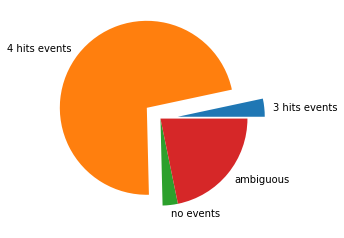

In [10]:
x = np.array([len(clearly3), len(clearly4), unique_no_events_counter, len(doubt)])
label = ["3 hits events", "4 hits events", "no events", "ambiguous"]

plt.pie( x , labels=label, explode=(0.2, 0.2, 0, 0))
print('all categories sum:', np.sum(x) )


These have clearly 3 hits


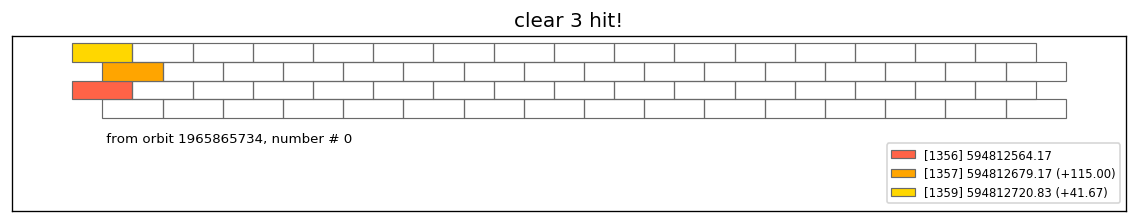

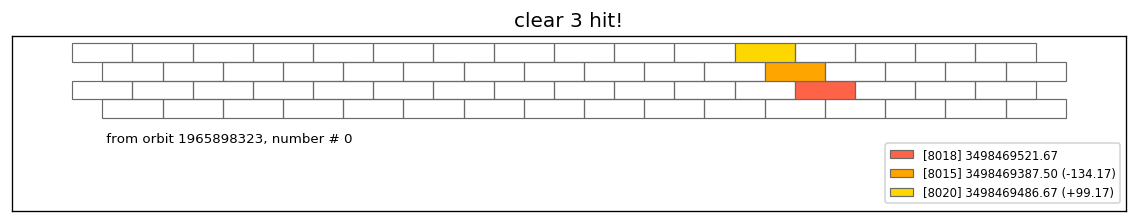


These have clearly 4 hits


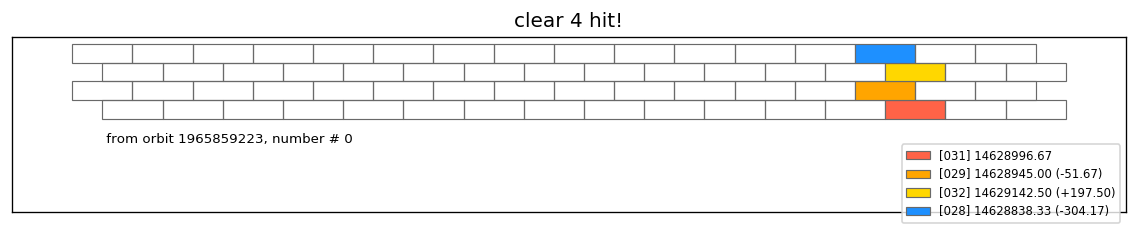

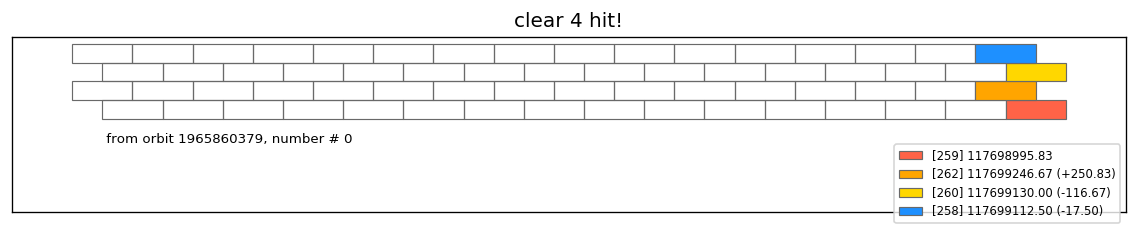

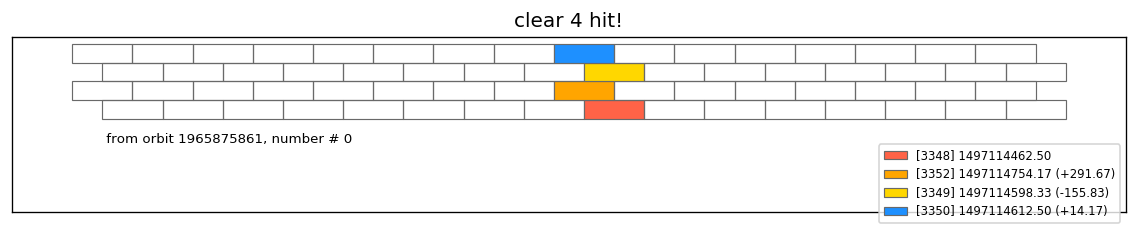


These are not events, but there is a trigger which tells me they should be...

These are ambiguous (more events for each orbit, or couple of 3s, ...


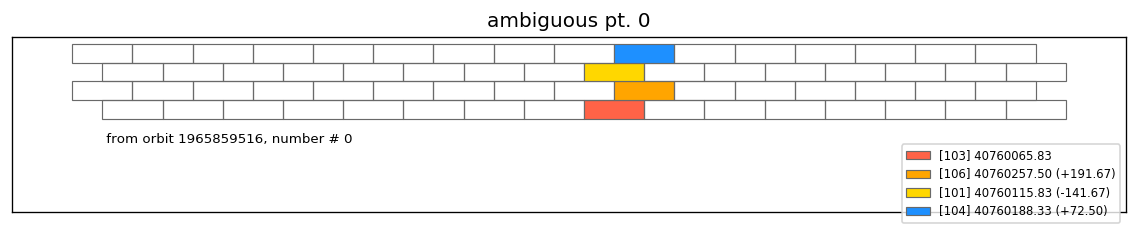

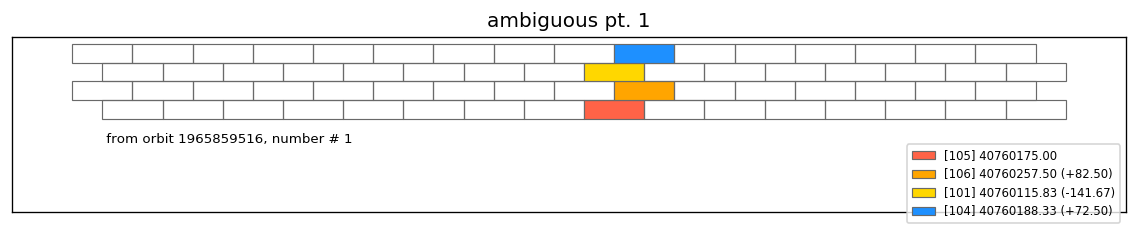

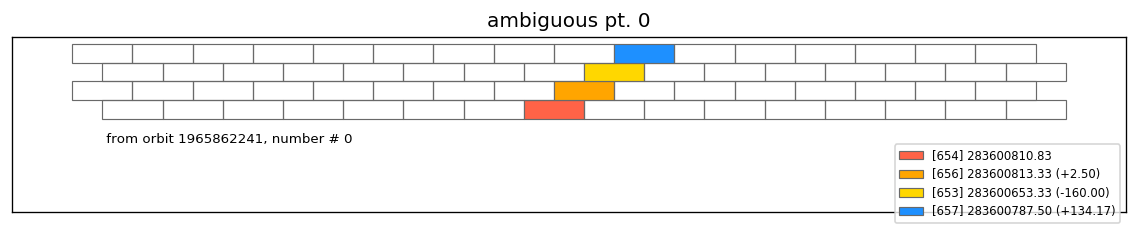

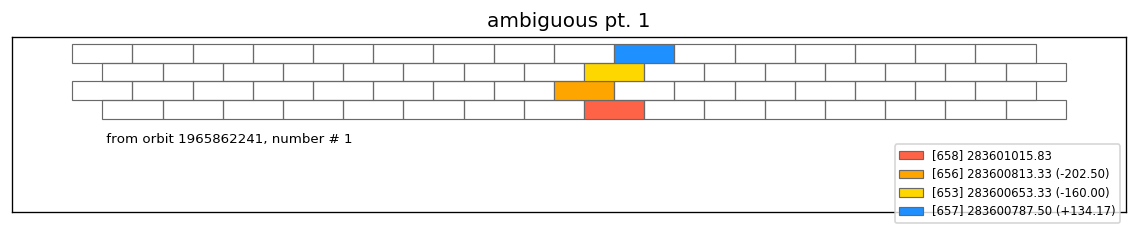

In [13]:
# let's visualize some of the data

print('\nThese have clearly 3 hits')
plot_event( clearly3[0], title='clear 3 hit!' )
plot_event( clearly3[6], title='clear 3 hit!' )

print('\nThese have clearly 4 hits')
plot_event( clearly4[0], title='clear 4 hit!' )
plot_event( clearly4[12], title='clear 4 hit!' )
plot_event( clearly4[117], title='clear 4 hit!' )

print('\nThese are not events, but there is a trigger which tells me they should be...')
#print(no_events[0:2])
#plot_event( no_events[0], title='no event' )
#plot_event( no_events[40], title='no event' )
#plot_event( no_events[-1], title='no event' )

print('\nThese are ambiguous (more events for each orbit, or couple of 3s, ...')
for i, dd in enumerate(doubt[0]):
    #print(dd)
    plot_event( dd , title = f'ambiguous pt. {i}')
for i, dd in enumerate(doubt[7]):
    #print(dd)
    plot_event( dd , title = f'ambiguous pt. {i}')

## Algorithm 2 (Ninni)

In [ ]:
"""
# DANIELE TEST

data = data[data['trigger'] == 0]   # why 'trigger'==1 rows all zero?
#data = data[0:100000]

def find_events(data):
    
    # find candidates corresponding to the 'left' configuration
    print('Finding candidates corresponding to the "left" configuration ...')
    left_size = data.groupby(['ORBIT_CNT', 'tile']).size().to_frame('size')
    left = data.join(left_size, on=['ORBIT_CNT', 'tile'])
    data_reduced = left[~ left['size'].between(3, 4)].drop('size', 1)   # 'tilde' inverts the mask
    left = left[left['size'].between(3, 4)]
    left['event_id'] = left['ORBIT_CNT'].astype(str) + '_' + left['tile'].astype(str) + '_L'

    # find candidates corresponding to the 'right' configuration
    print('Finding candidates corresponding to the "right" configuration ...')
    data_reduced.loc[data_reduced['layer'].isin([1, 3]), 'tile'] += 1
    right_size = data_reduced.groupby(['ORBIT_CNT', 'tile']).size().to_frame('size')
    right = data_reduced.join(right_size, on=['ORBIT_CNT', 'tile'])
    right = right[right['size'].between(3, 4)]
    right['event_id'] = right['ORBIT_CNT'].astype(str) + '_' + right['tile'].astype(str) + '_R'
    right.loc[data_reduced['layer'].isin([1, 3]), 'tile'] -= 1
   
    # build dataframe of events
    print('Building dataframe of events ...')
    events = pd.concat([left, right], ignore_index=True, sort=False)
    events = events.groupby('event_id').agg(list).reset_index()
    
    return events

events = find_events(data)
events
"""

def create_events_dataframe(lst):
    unwrapped = []
    for dic in lst:
        x = [None]*(3*4+2) # np.full(3*4+1, -1)   # modified!
        
        x[0] = dic['orbit']
        event = dic['event']
        
        layers_id = ''
        
        for ev in event:
            hit_id, time, l, tile = ev
            
            layers_id += str(l)
            
            l = l-1
            x[l*3 + 1] = hit_id
            x[l*3 + 2] = time
            x[l*3 + 3] = tile
            
        x[-1] = layers_id
        
        unwrapped.append(x)
    return pd.DataFrame(unwrapped, 
                        columns=['NORBIT', 
                                 'L1_HIT_ID', 'L1_TIME','L1_TILE','L2_HIT_ID', 'L2_TIME','L2_TILE',
                                 'L3_HIT_ID', 'L3_TIME','L3_TILE','L4_HIT_ID', 'L4_TIME','L4_TILE', 'LAYERS_ID'])

do = create_events_dataframe(clearly3 + clearly4)
do

#do.to_csv('/home/lab/dat/262_000_shifted.txt',index=False)

## Algorithm 3

This is much faster!

In [71]:
# DEMO:
events = []
df = data[ ((data['TDC_CHANNEL']).between(1,4,inclusive='both')) & (data['trigger'] ==0) ].sort_values(by=['detector','t'])  # selecting channels 

df['dt'] = df['t'] - df['t'].shift(1)  # calculating dt
df.loc[df['dt'] < 0, 'dt'] = 1000000   # solving detector interface issue
m = df['dt']<500                       # mask value with meaningful dt 
df = df[m.shift(-1)|m]                 # under-shift the mask

#chain, chain_len = [], 0
#for row in df[['t', 'layer','tile','dt']].itertuples():
#    if row.dt > 1000:  # it is the first element of a new time group
#        if ((chain_len == 3) or (chain_len == 4)): events.append( chain )
#        chain, chain_len =  [ (row.Index, row.t, row.layer, row.tile) ] , 0
#    else:
#        chain.append( (row.Index, row.t, row.layer, row.tile) )
#    chain_len += 1

#df['dt'].transform('first') > 500

df#[df['detector'] == 1]

47    4
Name: TDC_CHANNEL, dtype: int64

In [29]:
time_tolerance = 500      # tolerance parameter for time closeness

def close_hit_clustering(dataframe, time_tolerance = 500):
    events = []
    stat = np.zeros(20, dtype='int')  # to compute the frequency distribution of the chains
    
    for i in range(1,62,2):   # for alternative (bigger) mask use range(1,62,4) & (i,i+5)
        df = data[ ((data['TDC_CHANNEL']-1)%64).between(i-1,i+3-1,inclusive='both') ].sort_values(by=['detector','t'])  # selecting channels 

        df['dt'] = df['t'] - df['t'].shift(1)  # calculating dt
        df.loc[df['dt'] < 0, 'dt'] = 10e6      # solving detector interface issue
        m = df['dt'] < time_tolerance          # mask value with meaningful dt 
        df = df[m.shift(-1)|m]                 # under-shift the mask
    
        chain, chain_len = [], 0
        rep_checker = np.zeros(4)  # used to discard events with repetition through layers
        for row in df[['t', 'layer','tile','dt']].itertuples():
            if row.dt > time_tolerance:  # it is the first element of a new time group
                #stat[chain_len] += 1
                #if chain_len == 0: print(row)
                
                if (((chain_len == 3) or (chain_len == 4)) and (rep_checker.max()==1)): events.append( chain )
                chain, chain_len =  [ (row.Index, row.t, row.layer, row.tile) ] , 0
                rep_checker.fill(0);
            else:
                chain.append( (row.Index, row.t, row.layer, row.tile) )
            rep_checker[row.layer-1] += 1;      chain_len = chain_len + 1;
        
    return events

no_triggers = data[ data.trigger == 0 ]
evs = close_hit_clustering(no_triggers)
            
print(f'{len(evs)} events selected')
print('statistics:', stat )

160775 events selected
statistics: [    21      0 324971  86958  94907   8943   2028    556    110     13
      1      0      0      1      0      0      0      0      0      0]


In [65]:
def enhanced_close_hit_clustering(dataframe, time_tolerance = 500, keep_rejected = True):
    
    events = [] # list which stores the selected events
    
    # list which store the sensitivity-rejected events
    if keep_rejected: rejected = []

    for i in range(1,62,2):   # for alternative (bigger) mask use range(1,62,4) & (i,i+5)
    
        # margins for the active mask
        lma, rma = i, i+3
        # margins for the sensitivity mask (inclusive)
        lms, rms = max(0, i-4), min(64, i+7)
        
        # slicing by TDC_CHANNEL & selection
        df = data[ ((data['TDC_CHANNEL']-1)%64).between(lms-1,rms-1,inclusive='both') ].sort_values(by=['detector','t'])  # selecting channels 
        df['dt'] = df['t'] - df['t'].shift(1)  # calculating dt
        df.loc[df['dt'] < 0, 'dt'] = 10e6      # solving detector interface issue
        m = df['dt'] < time_tolerance          # mask value with meaningful dt 
        df = df[m.shift(-1)|m]                 # cross-shift the mask to take also the first event of each cluster
        
        # clustering over time and checking event shape
        reject = False
        chain, chain_len = [], 0
        
        rep_checker = np.zeros(4)  # used to discard candidates with hit repetition among layers
        for row in df[['TDC_CHANNEL','t', 'layer','tile','dt']].itertuples(): 
            
            # first element of a new cluster
            if row.dt > time_tolerance:
                
                # store if value is good
                if (((chain_len == 3) or (chain_len == 4)) and (rep_checker.max()==1)):
                    if not reject: events.append( chain )
                    elif keep_rejected: rejected.append( chain )
                
                # resetting the data structure
                reject = False
                chain, chain_len =  [ (row.Index, row.t, row.layer, row.tile) ] , 0
                rep_checker.fill(0);
            
            # another element of cluster
            else:
                chain.append( (row.Index, row.t, row.layer, row.tile) )
            
            # checking if hit is in active mask
            if (lma <= row.TDC_CHANNEL <= rma):  
                rep_checker[row.layer-1] += 1; 
                chain_len = chain_len + 1;
            else:
                reject = True

    
    if keep_rejected: return events, rejected
    else: return events, []

no_triggers = data[ data.trigger == 0 ]
evs, dis = enhanced_close_hit_clustering(no_triggers)

print(f'{len(evs)} events selected')
print(f' {len(dis)} events discarded')
#print('statistics:', stat )

56941 events selected
 23144 events discarded


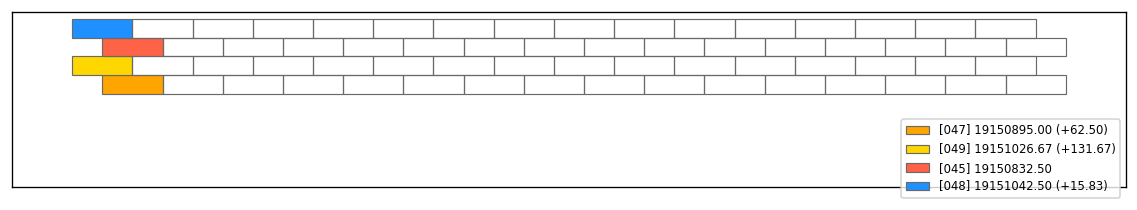

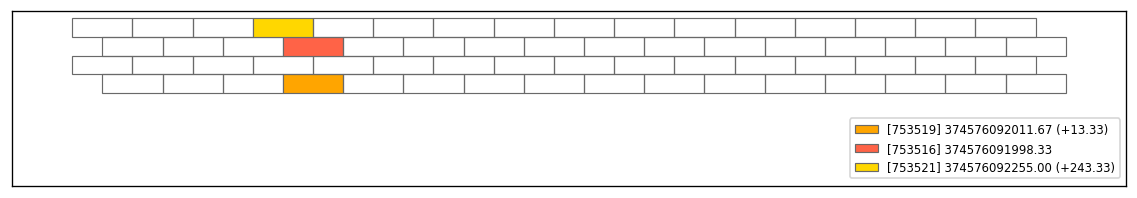

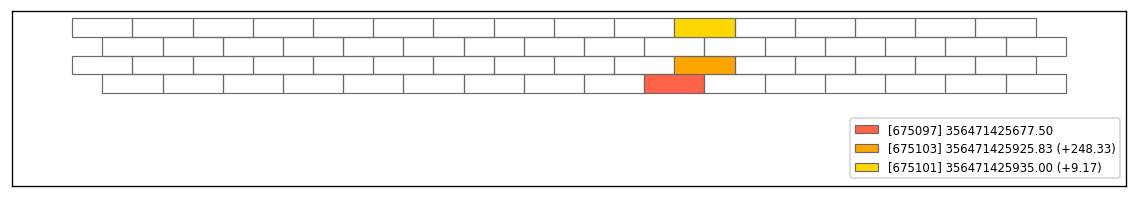

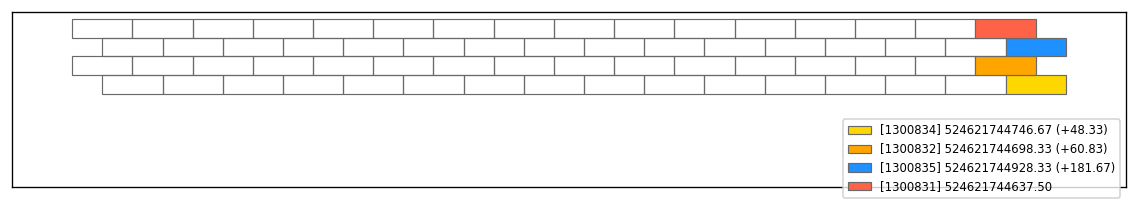

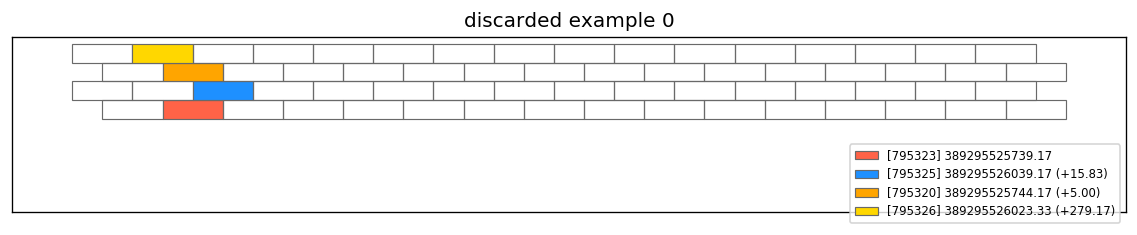

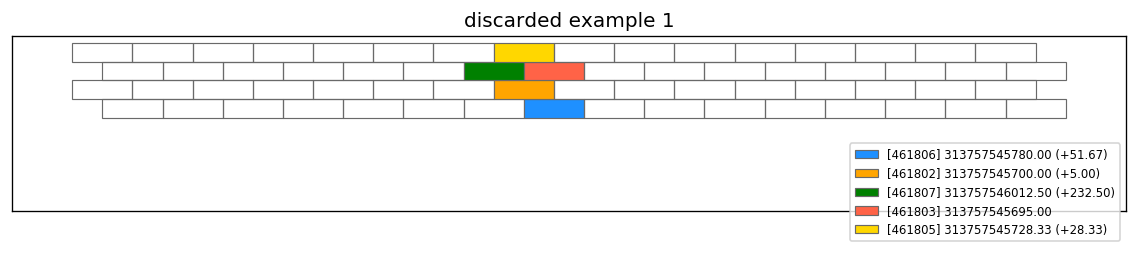

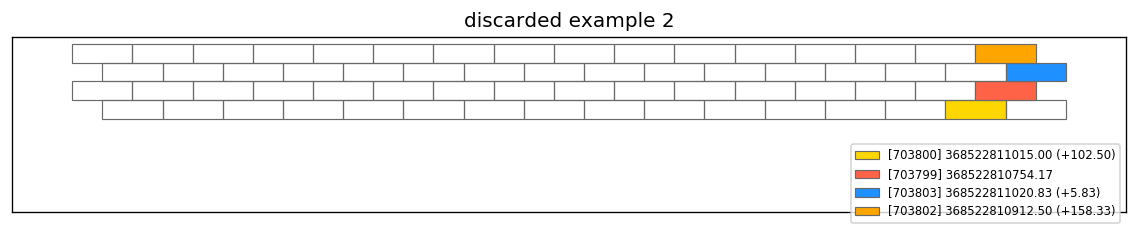

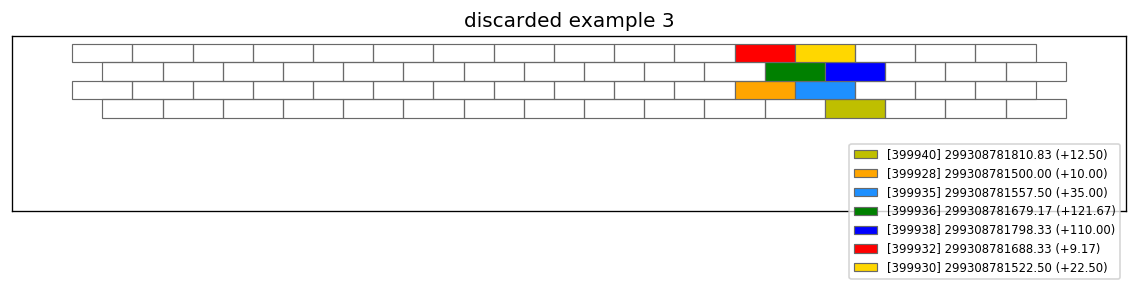

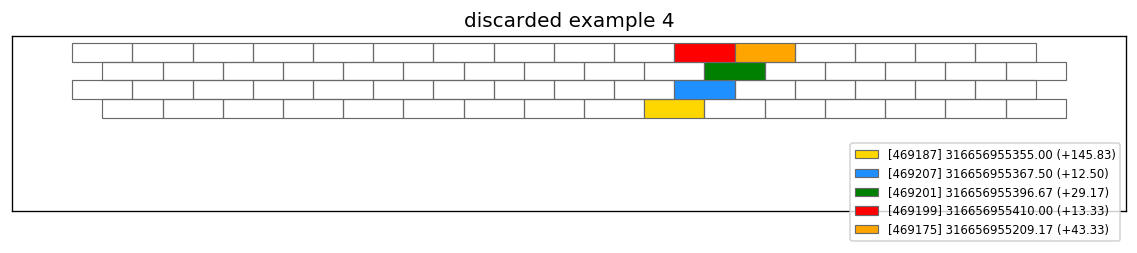

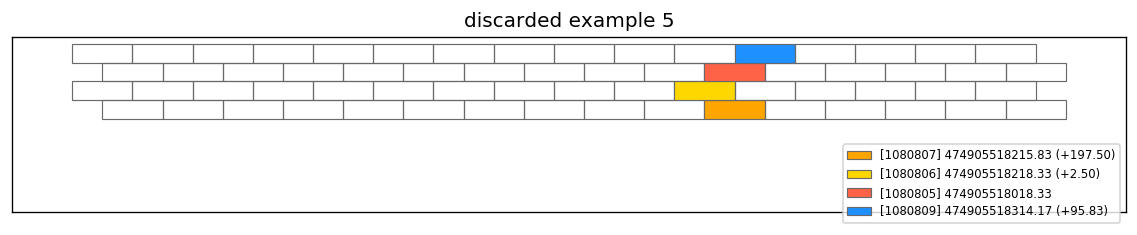

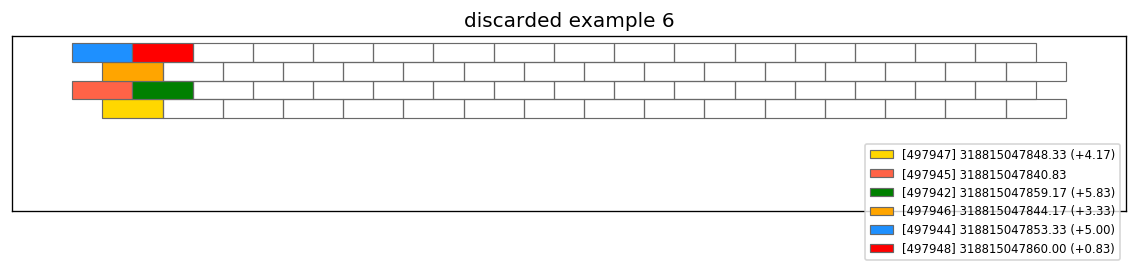

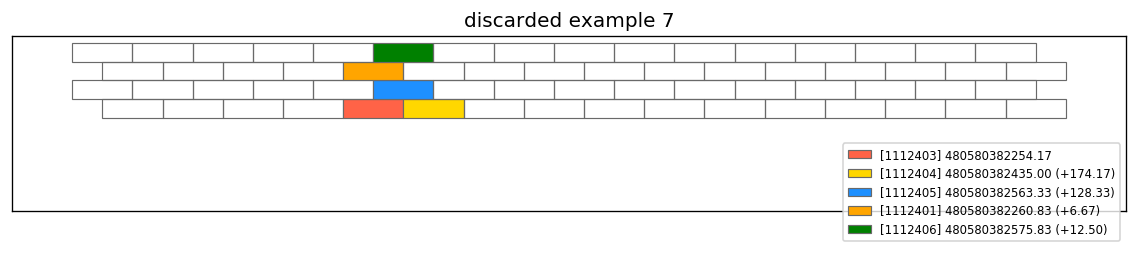

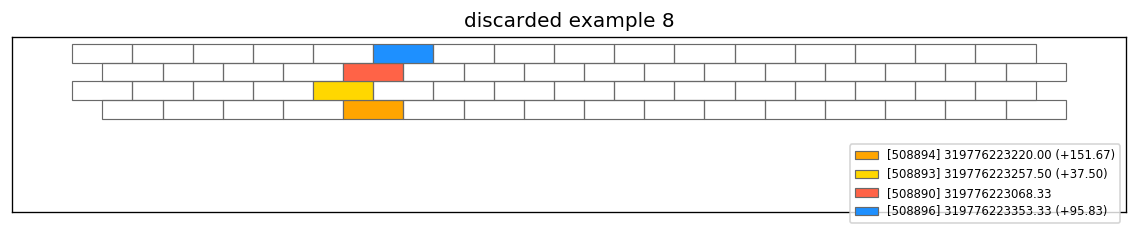

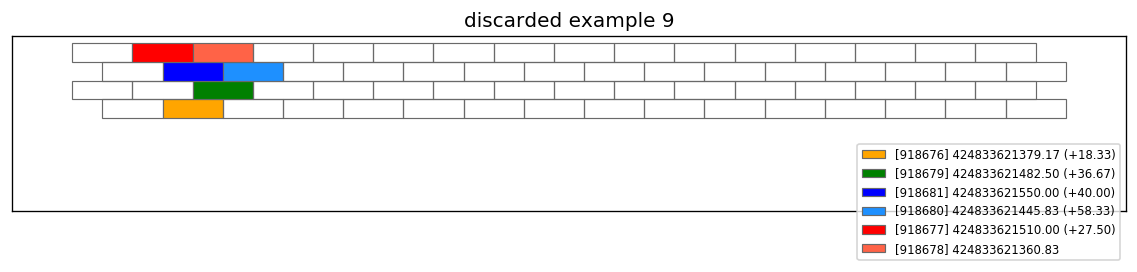

In [69]:
plot_events_from_tiles( evs[0] );
plot_events_from_tiles(evs[10774]);
plot_events_from_tiles(evs[30774]);
#plot_events_from_tiles(events[70774]);
#plot_events_from_tiles(events[130774]);
plot_events_from_tiles(evs[-1]);

for i in range(10):
    y = np.random.randint(0, len(dis))
    plot_events_from_tiles( dis[y], title = f'discarded example {i}');
    
#plot_events_from_tiles(dis[3232], title = 'discarded example');  #3232
#plot_events_from_tiles(dis[7232], title = 'discarded example');
#plot_events_from_tiles(dis[23142], title = 'discarded example');
#1247954

## Saving to file
```python
# evento chiaramente 4 hit
  {'orbit': 1965859223, 'orbit_event': 0, 'event': [(31, 14628996.666666666, 1, 13), (29, 14628945.0, 2, 13), (32, 14629142.5, 3, 13), (28, 14628838.333333334, 4, 13)]}
# evento chiaramente 3 hit
  {'orbit': 1965865734, 'orbit_event': 0, 'event': [(1356, 594812564.1666666, 2, 0), (1357, 594812679.1666666, 3, 0), (1359, 594812720.8333334, 4, 0)]}
```

The dataframe conversion for these two events would look like:

|NORBIT |L1_HIT_ID |L1_TIME |L1_TILE |L2_HIT_ID |L2_TIME |L2_TILE |L3_HIT_ID |L3_TIME |L3_TILE |L4_HIT_ID |L4_TIME |L4_TILE|
|----|----|----|----|----|----|----|----|----|----|----|----|----|
|0 |1965865734 |NaN |NaN |NaN |1356.0 |5.948126e+08 |0.0 |1357.0 |5.948127e+08 |0.0 |1359.0 |5.948127e+08 |0.0|
|1 |1965859223 |31 |1.462900e+07 |13 |29 |1.462894e+07|13 |32 |1.462914e+07 |13 |28 |1.462884e+07 |13|

For 3-hit events, the dataframe places NaN for the missing layer.

In [12]:
print('evento chiaramente 4\n ', clearly4[0])
print('evento chiaramente 3\n ', clearly3[0])

evento chiaramente 4
  {'orbit': 1965859223, 'orbit_event': 0, 'event': [(31, 14628996.666666666, 1, 13), (29, 14628945.0, 2, 13), (32, 14629142.5, 3, 13), (28, 14628838.333333334, 4, 13)]}
evento chiaramente 3
  {'orbit': 1965865734, 'orbit_event': 0, 'event': [(1356, 594812564.1666666, 2, 0), (1357, 594812679.1666666, 3, 0), (1359, 594812720.8333334, 4, 0)]}


In [27]:
def create_events_dataframe(lst):
    unwrapped = []
    for dic in lst:
        x = [None]*(3*4+1) # np.full(3*4+1, -1)
        
        x[0] = dic['orbit']
        event = dic['event']
        
        for ev in event:
            hit_id, time, l, tile = ev
            l = l-1
            x[l*3 + 1] = hit_id
            x[l*3 + 2] = time
            x[l*3 + 3] = tile
        
        unwrapped.append(x)
    return pd.DataFrame(unwrapped, 
                        columns=['NORBIT', 
                                 'L1_HIT_ID', 'L1_TIME','L1_TILE','L2_HIT_ID', 'L2_TIME','L2_TILE',
                                 'L3_HIT_ID', 'L3_TIME','L3_TILE','L4_HIT_ID', 'L4_TIME','L4_TILE'])

do = create_events_dataframe(evs)
do

#do.to_csv('/home/lab/dat/262_000_shifted.txt',index=False)

TypeError: list indices must be integers or slices, not str

# TRASH
from this point on, it is just a collection of old codes

In [14]:
#triggers = data[data['trigger']==1]

counter = 0
keep4 = []
keep3 = []

for value in this_shit[["ORBIT_CNT"]].values:
    orbit = int(value)
    most_common = int(stats.mode(data[ data["ORBIT_CNT"]==orbit ][["detector"]])[0])
    
    dgg = df.get_group((orbit,most_common))
    dgg = dgg.sort_values(by=['t','layer'])
    dgg
    
    events = []
    dsel = dgg[(dgg['layer'] <3)].index.values.tolist()
    for dd in dsel:
        build(dd,'')
    
    if not events:
        continue
    commas = max( [ (ev.count(",")+1) for ev in events ] )
    if commas == 4:
        keep4.append(  (orbit,most_common) )
    elif commas == 3:
        keep3.append(  (orbit,most_common) )
    counter += 1
    
    if counter == 1000:
        break

    
print(len(keep4),len(keep3), counter)

NameError: name 'this_shit' is not defined

In [ ]:
# select an orbit from df
#dgg = df.get_group((1897415301,2))
#dgg = df.get_group((1965859223,2))   # this works
#dgg = df.get_group((1965860241,2))
#dgg = df.get_group((1971794500,4))
#dgg = df.get_group((1965861619,1))
dgg = df.get_group((1965860571, 2))  # this works with 2 events
#dgg = df.get_group((1965942290, 3))

dgg = dgg.sort_values(by=['t','layer'])
dgg

In [ ]:
events = []

dt = 415

def build(hit_id, stri):
    #print(f'\nbuild called with {hit_id}')
    stri = stri + str(hit_id)
    
    me = dgg.loc[ hit_id ]
    t = me.t
    l = int(me.layer)
    c = me.tile
    
    # find candidates
    candidates = []
    for dl in range(1,5-l):  # check if last value is included!
        lay = l+dl
        #print(f' looking at layer {lay}')
        c_up = c + math.ceil((dl-(l%2))/2)
        c_down = c + math.floor((-dl+((l-1)%2))/2)
        #print(f' for indexes {c_down} to {c_up}')
        candidate_df = (dgg['layer'] == l+dl) & (dgg['t'] > t-dt) & (dgg['t'] <= t+dt*dl) & (dgg['tile'] <= c_up) & (dgg['tile']>= c_down)
        candidates = candidates + dgg[candidate_df].index.values.tolist()
    
    #print(candidates)
    if not candidates:
        events.append( stri + ';' )
    
    for cc in candidates:
        if dgg.loc[ cc ].layer != 4:
            build(cc, stri + ',')
        else:
            events.append( stri + f',{cc};' )


dsel = dgg[(dgg['layer'] <3)].index.values.tolist()
for dd in dsel:
    build(dd,'')

#events = list(set(events))  # to delete duplicates
print(f'algo selected {len(events)} unique candidates')
print(events)

#events = [ ev for ev in events if ev.count(",") > 1 ]
print(f'algo selected {len(events)} candidates with 3 or more hits:')
print(events)

In [ ]:
#  https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle

print(events)

def read_event(stri):
    sel = [ int(i) for i in stri.replace(";", "").split(",") ]
    
    ev = []
    for hit in sel:
        me = dgg.loc[hit]
        l = int(me.layer)
        tile = int(me.tile)
        time = me.t
        
        ev.append( (l,tile,time,hit) )
    return ev


def plot_events(ev, detector_number = None):
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # create the the detector pattern
    dx, dy =  42, 10            # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    tiles = []
    for jj in range(n_layers):
        row = []
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx+dx*(jj%2)/2,jj*dy),dx,dy, edgecolor='dimgray',facecolor='none', linewidth=0.7)
            ax.add_patch( t )
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
            row.append(t)
        tiles.append(row)
        
    plt.xlim(-dx/2, dx*n_tiles + dx)
    plt.ylim(-dy*5, dy*n_layers + 5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    #plt.axis('off')  # completely turn off the axis
    
    if detector_number:
        ax.text(0, -5, f'Detector {detector_number}')
    
    color_list = ['tomato','orange','gold','dodgerblue', 'green']
    for idx, e in enumerate(ev):
        lal = "[{:03d}] {:.2f}".format(e[3],e[2])
        if idx != 0:
            lal += " ({:+.2f})".format(e[2]-prev_time)
        tiles[e[0]-1][e[1]].set(facecolor=(color_list[idx]),label=lal)
        prev_time = e[2]
        #legend_handles.append(tiles[e[0]-1][e[1]])
    
    plt.legend(prop={'size': 9})

    #ax.text(0, -5, time_string.rstrip(', '), fontsize=8)
    
    return tiles


for cc in events:
    plot_events( read_event(cc) )
plt.show()


In [ ]:
this_shit = data[data['trigger']==1]

counter = 0
keep4 = []
keep3 = []

for value in this_shit[["ORBIT_CNT"]].values:
    orbit = int(value)
    most_common = int(stats.mode(data[ data["ORBIT_CNT"]==orbit ][["detector"]])[0])
    
    dgg = df.get_group((orbit,most_common))
    dgg = dgg.sort_values(by=['t','layer'])
    dgg
    
    events = []
    dsel = dgg[(dgg['layer'] <3)].index.values.tolist()
    for dd in dsel:
        build(dd,'')
    
    if not events:
        continue
    commas = max( [ (ev.count(",")+1) for ev in events ] )
    if commas == 4:
        keep4.append(  (orbit,most_common) )
    elif commas == 3:
        keep3.append(  (orbit,most_common) )
    counter += 1
    
    if counter == 1000:
        break

    
print(len(keep4),len(keep3), counter)

In [ ]:
print(keep4[5])  # lucky bastards!
print(keep3[343])